## Fireworks and LangChain tools

We want to build some basic agents that ties a bunch of tools defined in LangChain together. We will use a Fireworks open source model, firefunction-v1, to power this tutorial. We will now define some LangChain tools and use that with ChatFireworks.

In [1]:
import { ChatFireworks } from "@langchain/community/chat_models/fireworks";

In [2]:
/** Define the chat model */
const llm = new ChatFireworks({
  modelName: "accounts/fireworks/models/firefunction-v1",
  temperature: 0,
});

We'll define two tools to start:

- `search_answer`, whenever we are not sure if the bot should answer the question or not
- `get_stock_price`, whenever we are feeling lucky and want to check what the stock price is

These will be stubbed out, and are just for defining output schemas for the models.

In [3]:
import { z } from "zod";
import { StructuredTool } from "@langchain/core/tools";
import { formatToOpenAITool } from "@langchain/openai";

class SearchAnswer extends StructuredTool {
  name = "search_answer";
  
  description = "Search online for an answer only when you are not confident with the answer.";

  schema = z.object({
    query: z.string().describe("Query to use for the search engine."),
  });

  constructor() {
    super();
  }

  _call(input: z.infer<typeof this["schema"]>): Promise<string> {
    return Promise.resolve(JSON.stringify(input, null, 2));
  }
}

class GetStockPrice extends StructuredTool {
  name = "get_stock_price";
  
  description = "Get the stock price for a company.";

  schema = z.object({
    ticker: z.string().describe("Ticker for the company we are interested in."),
  });

  constructor() {
    super();
  }

  _call(input: z.infer<typeof this["schema"]>): Promise<string> {
    return Promise.resolve(JSON.stringify(input, null, 2));
  }
}

const searchTool = formatToOpenAITool(new SearchAnswer());
const stockTool = formatToOpenAITool(new GetStockPrice());
const tools1 = [searchTool, stockTool];

First, we will just ask some basic question for the model, and see if it knows to give an answer on the spot or not

In [4]:
const llmWithTool1 = llm.bind({
  tools: tools1,
});

const exampleQ = `What's Yosemite?`;

await llmWithTool1.invoke(exampleQ);

AIMessage {
  lc_serializable: true,
  lc_kwargs: {
    content: "Yosemite is a national park located in California, United States. It is known for its stunning natur"... 65 more characters,
    additional_kwargs: { function_call: undefined, tool_calls: undefined }
  },
  lc_namespace: [ "langchain_core", "messages" ],
  content: "Yosemite is a national park located in California, United States. It is known for its stunning natur"... 65 more characters,
  name: undefined,
  additional_kwargs: { function_call: undefined, tool_calls: undefined }
}

So for an easy question, the model just gave a reply on the spot.

Now let's ask the model something it definitely doesn't know. We just had the superbowl a few days ago, does the model knows to go to the search engine instead of hallucinate some random answer?

In [5]:
const llmWithTool1 = llm.bind({
  tools: tools1,
});

const exampleQ = `Which team won the superbowl in 2024?`;

await llmWithTool1.invoke(exampleQ);

AIMessage {
  lc_serializable: true,
  lc_kwargs: {
    content: "I don't have the information about the Superbowl winner in 2024. Let me search online for the answer"... 2 more characters,
    additional_kwargs: {
      function_call: undefined,
      tool_calls: [
        {
          index: 0,
          id: "call_DRyGeHu0JVG3tQOzm7Czy9HV",
          type: "function",
          function: [Object]
        }
      ]
    }
  },
  lc_namespace: [ "langchain_core", "messages" ],
  content: "I don't have the information about the Superbowl winner in 2024. Let me search online for the answer"... 2 more characters,
  name: undefined,
  additional_kwargs: {
    function_call: undefined,
    tool_calls: [
      {
        index: 0,
        id: "call_DRyGeHu0JVG3tQOzm7Czy9HV",
        type: "function",
        function: {
          name: "search_answer",
          arguments: '{"query": "Superbowl winner 2024"}'
        }
      }
    ]
  }
}

The model didn't hallucinate and went for the search engine instead! Pretty cool right?

Now we are feeling lucky, let's see if the model can give us some price movements for Nvidia.

In [6]:
const llmWithTool1 = llm.bind({
  tools: tools1,
});

const exampleQ = `What is the price of Nvidia shares now?`;

await llmWithTool1.invoke(exampleQ);

AIMessage {
  lc_serializable: true,
  lc_kwargs: {
    content: "",
    additional_kwargs: {
      function_call: undefined,
      tool_calls: [
        {
          index: 0,
          id: "call_dLiUe0wGYPFsRoQJ7EZyemSm",
          type: "function",
          function: [Object]
        }
      ]
    }
  },
  lc_namespace: [ "langchain_core", "messages" ],
  content: "",
  name: undefined,
  additional_kwargs: {
    function_call: undefined,
    tool_calls: [
      {
        index: 0,
        id: "call_dLiUe0wGYPFsRoQJ7EZyemSm",
        type: "function",
        function: { name: "get_stock_price", arguments: '{"ticker": "NVDA"}' }
      }
    ]
  }
}

Looks like the model knows Nvidia's ticker is NVDA, and also understand the concept of the ticker.

Now the final experiment, we want to make some doodles that are LangChain and Fireworks related.

We can force the LLM to call our image tool, then create a chain that invokes the tool we declared. Let's see how that goes:

In [7]:
function _arrayBufferToBase64(buffer) {
  let binary = '';
  let bytes = new Uint8Array(buffer);
  let len = bytes.byteLength;
  for (let i = 0; i < len; i++) {
      binary += String.fromCharCode( bytes[ i ] );
  }
  return window.btoa(binary);
}

class GenerateImage extends StructuredTool {
  name = "generate_image";
  
  description = "Pass an image description to an AI to generate an image.";

  schema = z.object({
    detailed_description: z.string().describe("A very detailed description for the image."),
  });

  constructor() {
    super();
  }

  async _call(input: z.infer<typeof this["schema"]>): Promise<string> {
    const response = await fetch(
      "https://api.fireworks.ai/inference/v1/image_generation/accounts/fireworks/models/stable-diffusion-xl-1024-v1-0",
      {
        headers: {
          "Authorization": `Bearer ${process.env.FIREWORKS_API_KEY}`,
          "Accept": "image/jpeg",
          "Content-Type": "application/json",
        },
        method: "POST",
        body: JSON.stringify({ prompt: input.detailed_description })
      }
    );
    // Buffer is not available in Deno, otherwise this would be easier
    const buffer = await response.arrayBuffer();
    console.log(_arrayBufferToBase64(buffer));
    return _arrayBufferToBase64(buffer);
  }
}

In [8]:
import { JsonOutputToolsParser } from "langchain/output_parsers";
import { RunnableSequence } from "@langchain/core/runnables";

const generateImageTool = new GenerateImage();

const llmWithTool1 = llm.bind({
  tools: [formatToOpenAITool(generateImageTool)],
  tool_choice: {
    type: "function",
    name: "generate_image",
  }
});

const exampleQ = `Give me an image with a bird with fireworks in the background?`;

// We can pipe the called tool into a chain to generate an image with the result
const toolChain = RunnableSequence.from([
  llmWithTool1,
  new JsonOutputToolsParser(),
  (toolInvocation) => toolInvocation[0].args,
  generateImageTool,
]);

const imageBase64 = await toolChain.invoke(exampleQ);

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAQABAADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD8mBnsMH6UY4z/ADFKuMcGlwcYzivcPnERsCM4PHrTfp/KpCeeKaR7/hTSuIQDjr+lG0nml5HfnvmjHc0+UrlEK96QowHIp+0YwKOQOv60JAkRkHIoCEdDTzgjkUY4osFkR4PQfypD15AqQ+npTSpz/hTsxOIzBPSkwSaeV4/+

And here is the generated image with Fireworks SDXL API based on the query generated by the tool!

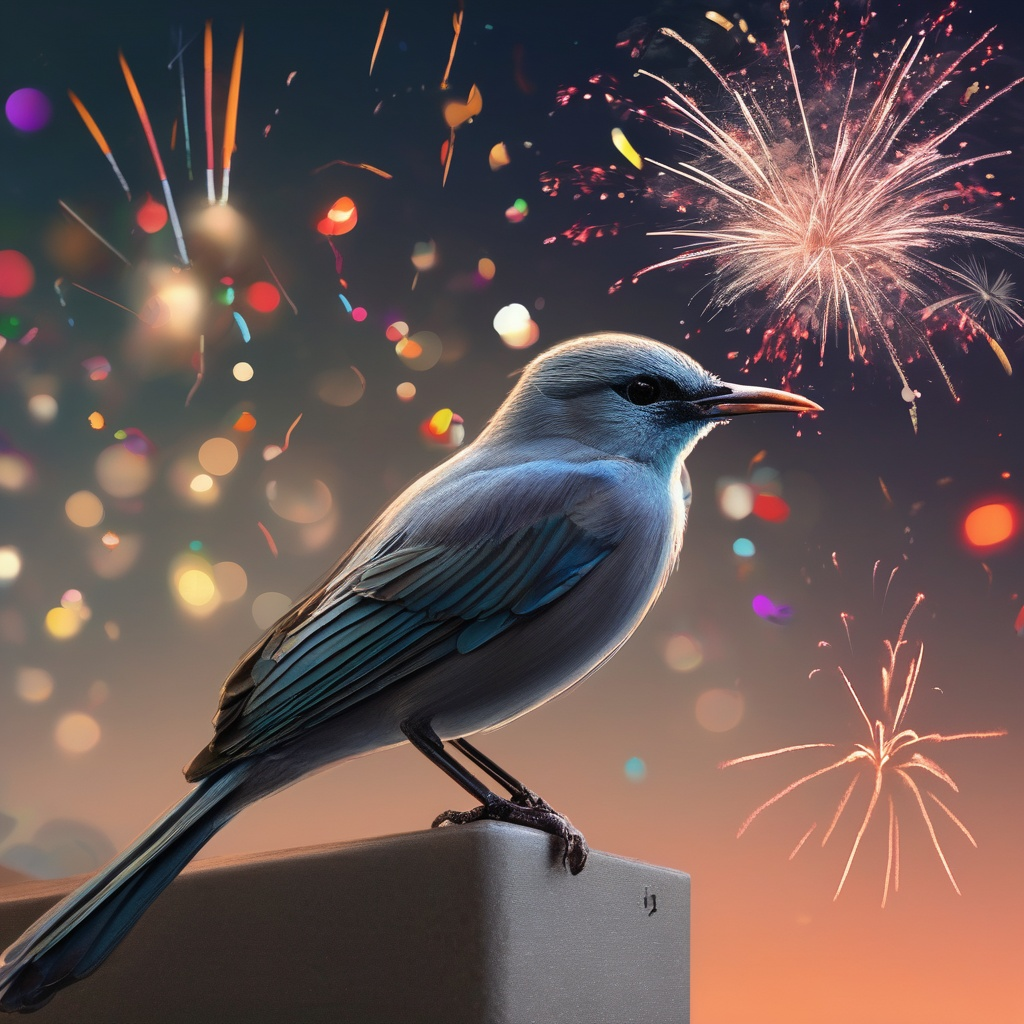

In [9]:
{
  [Symbol.for("Jupyter.display")]() {
    return {
      "image/jpeg": imageBase64
    }
  }
}

We would love to hear your feedback if you run into any issues with the model, or any integration issues with Fireworks and LangChain, so check out https://fireworks.ai, and ping us on Discord if you find any issues.